<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing-and-Data-Loading" data-toc-modified-id="Preprocessing-and-Data-Loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing and Data Loading</a></span><ul class="toc-item"><li><span><a href="#Import-necessary-modules" data-toc-modified-id="Import-necessary-modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import necessary modules</a></span></li><li><span><a href="#Some-Comments-on-Preprocessing" data-toc-modified-id="Some-Comments-on-Preprocessing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Some Comments on Preprocessing</a></span></li><li><span><a href="#Loading-the-Data-via-Pytorch-DataLoader" data-toc-modified-id="Loading-the-Data-via-Pytorch-DataLoader-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Loading the Data via Pytorch DataLoader</a></span></li></ul></li><li><span><a href="#Build-a-Convolutional-Neural-Network(CNN)-Architecture" data-toc-modified-id="Build-a-Convolutional-Neural-Network(CNN)-Architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build a Convolutional Neural Network(CNN) Architecture</a></span><ul class="toc-item"><li><span><a href="#What-CNNs-Learn" data-toc-modified-id="What-CNNs-Learn-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>What CNNs Learn</a></span></li></ul></li><li><span><a href="#Train-and-Test" data-toc-modified-id="Train-and-Test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train and Test</a></span></li><li><span><a href="#Post-Processing" data-toc-modified-id="Post-Processing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Post-Processing</a></span><ul class="toc-item"><li><span><a href="#Display-The-Predictions-with-Ground-Truths" data-toc-modified-id="Display-The-Predictions-with-Ground-Truths-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Display The Predictions with Ground Truths</a></span></li><li><span><a href="#Visualize-the-Filters-and-Feature-Maps-Again" data-toc-modified-id="Visualize-the-Filters-and-Feature-Maps-Again-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualize the Filters and Feature Maps Again</a></span></li><li><span><a href="#Evaluate-the-Performance-Metrics" data-toc-modified-id="Evaluate-the-Performance-Metrics-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Evaluate the Performance Metrics</a></span><ul class="toc-item"><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Confusion Matrix</a></span></li><li><span><a href="#Overall-Accuracy" data-toc-modified-id="Overall-Accuracy-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Overall Accuracy</a></span></li><li><span><a href="#Recall" data-toc-modified-id="Recall-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>Recall</a></span></li><li><span><a href="#Precision" data-toc-modified-id="Precision-4.3.4"><span class="toc-item-num">4.3.4&nbsp;&nbsp;</span>Precision</a></span></li><li><span><a href="#F1-Score" data-toc-modified-id="F1-Score-4.3.5"><span class="toc-item-num">4.3.5&nbsp;&nbsp;</span>F1-Score</a></span></li></ul></li></ul></li></ul></div>

## Preprocessing and Data Loading

### Import necessary modules

In [1]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

    #import modules here if necessary
    !pip install torchinfo

    #make-dirs
    !mkdir -p '/content/House_Rooms_Dataset/train'
    !mkdir -p '/content/House_Rooms_Dataset/test'
    !mkdir -p '/content/results/House_Rooms'
    
    #define test-train-ext dirs
    train_dir = '/content/House_Rooms_Dataset/train'
    test_dir = '/content/House_Rooms_Dataset/test'
    ext_dir = '/content/results/House_Rooms'

    #modify here
    !unzip -u '/content/drive/MyDrive/ColabNotebooks/SpelmanResearch/datasets/House_Rooms_Resized/train.zip' -d '/content/House_Rooms_Dataset'
    !unzip -u '/content/drive/MyDrive/ColabNotebooks/SpelmanResearch/datasets/House_Rooms_Resized/test.zip' -d '/content/House_Rooms_Dataset'
else:
    #change this to your own local directories if you dont work on Colab
    train_dir = 'datasets/House_Room_Dataset_Resized/train/'
    test_dir = 'datasets/House_Room_Dataset_Resized/test/'
    ext_dir =  'results/House_Rooms/'

In [2]:
#==============================#
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
#===========================#
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
#============================#
import os
import random
import sys
from torchinfo import summary
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore') 
#==============================#
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2070 Super


### Some Comments on Preprocessing 

-  We will be working on House_Room dataset [here](https://www.kaggle.com/robinreni/house-rooms-image-dataset). Task is to classify five room types of houses. 
-  Original dataset has around 5000 images of size 224x224 RGB and does not have train-test folders. It is composed of just root directory and class folders in it. We would like to create subset of it.
- Perform train-test split via *CreateTrainTest*. This function will scan the images in each class, mark as training and testing and copy them 'train' and 'test' folders in the same directory.
- Resize all the images to 60x60 via *ResizeSave*. In order to speep-up the training, resizing was performed before training, not as part of augmentation. This step is usually overlooked in many application. However, resizing is a big bottlenect significantly increasing the training time.  

-  After these steps, we have a folder called 'House_Room_Dataset_Resized'. This will be our root directory from now on. Let's keep these functions in a seperate directory python file "HelperFunctions.py". We can import and use them whenever we want.

### Loading the Data via Pytorch DataLoader

- Pytorch provides several classes which make the data loading easy and fast.
- It is essential to perform data augmentation on the training data. Core idea is to feed different batch of modified images to the model. Please carefully read the section 'Improving Neural Networks' in the report in our repository. 
- We have just one data augmentation here which is to 'Shuffle' the images in each batch. In the second part of this notebook, we will introduce more augmentation with convolutional neural networks.Thus, consider this part as the experimental stage.

In [3]:
#reading and loading the data
mean = [0.485, 0.456, 0.406]
std =  [0.229, 0.224, 0.225]
training_transforms = transforms.Compose([transforms.ToTensor(),
                                         #transforms.Normalize(mean,std)
                                         ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                     #transforms.Normalize(mean,std)
                                     ])


train_set = datasets.ImageFolder(train_dir, transform = training_transforms)
test_set  = datasets.ImageFolder(test_dir, transform = test_transforms)

batch_size = 10
train_loader = DataLoader(train_set,batch_size = batch_size,drop_last=True,shuffle=True)
test_loader = DataLoader(test_set,batch_size = batch_size)

In [4]:
#let's see what we got from dataset class
class_list = train_set.classes
class_to_idx = train_set.class_to_idx
idx_to_class = {i:j for i, j in enumerate(class_list)}
num_classes = len(class_list)

print('class_list:', class_list)
# print('class_to_idx: ',class_to_idx)
# print('num_classes: ', num_classes)

class_list: ['Bathroom', 'Bedroom', 'Dinning', 'Kitchen', 'Livingroom']


The following output is important. Since we set batch_size = 10, we have 10 images in each 'load' and 10 labels corresponding to each of these images.

In [5]:
images, labels = iter(train_loader).next()
print(images.shape)
print(labels)

torch.Size([10, 3, 60, 60])
tensor([0, 4, 3, 4, 3, 3, 4, 3, 2, 1])


In [6]:
#80%-20%
print(f'train_set has {len(train_set)} images')
print(f'testing_set has {len(test_set)} images')

train_set has 4198 images
testing_set has 1052 images


In [7]:
def GetDataPaths(train_dir,test_dir):
    train_image_paths = []
    test_image_paths = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):
        for names in filenames:
            train_image_paths.append(os.path.join(dirpath,names))
    for (dirpath, dirnames, filenames) in os.walk(test_dir):
        for names in filenames:
            test_image_paths.append(os.path.join(dirpath,names))

    random.shuffle(train_image_paths)
    random.shuffle(test_image_paths)
    
    return train_image_paths,test_image_paths

train_image_paths,test_image_paths = GetDataPaths(train_dir, test_dir)

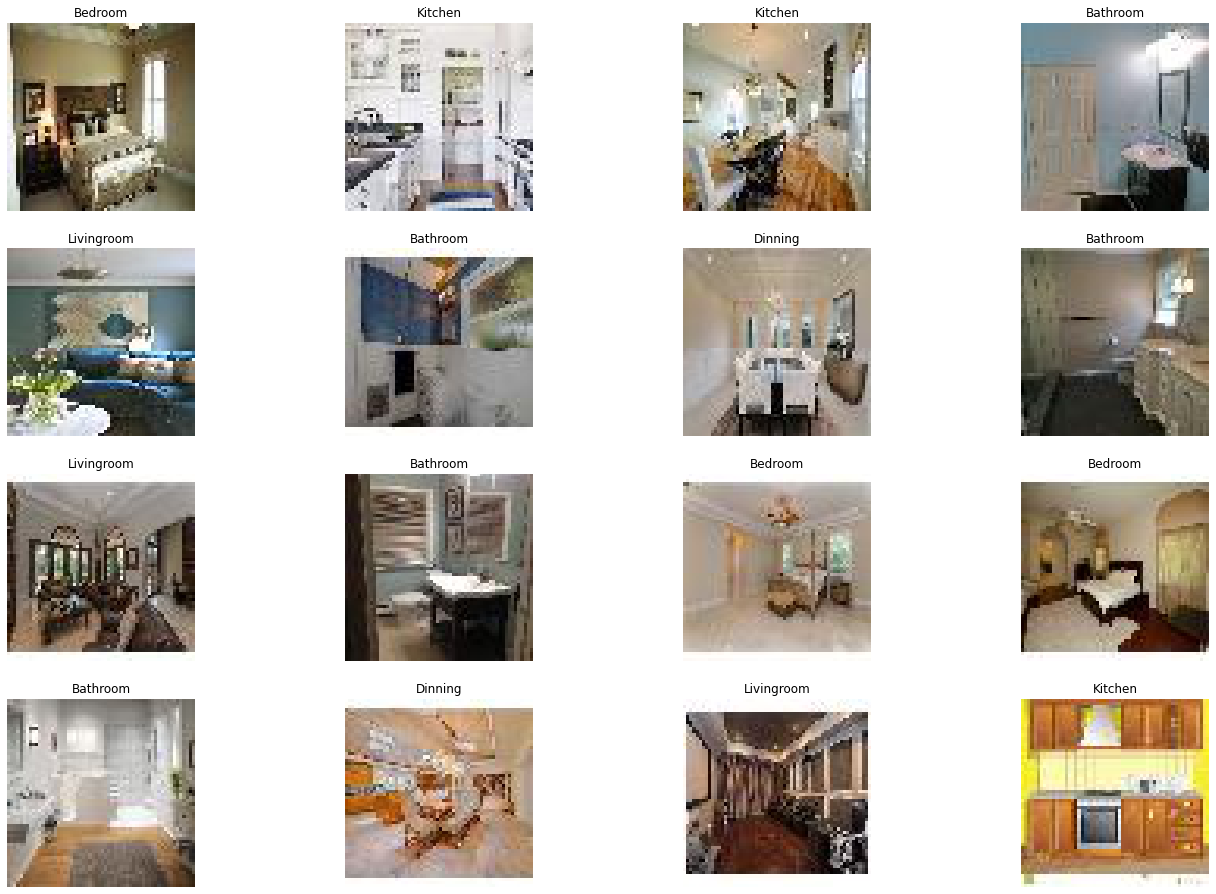

In [8]:
#let's look at some images
def ViewSamples(n,parentdir):
    # show nxn random samples from parentdir
    f,ax = plt.subplots(n,n) 
    f.subplots_adjust(0,0,3,3)#(left,bottom,vertical_distance b/w columns)
    for i in range(0,n,1):
        for j in range(0,n,1):
            rnd_number = random.randint(0,len(test_image_paths))
            img_path = test_image_paths[rnd_number]
            img_label = img_path.split('/')[-2]
            image = Image.open(img_path).convert("RGB")
            ax[i,j].imshow(image)
            ax[i,j].set_title(img_label)
            ax[i,j].axis('off')

ViewSamples(4,test_image_paths)

- A common practice is to check the class distributions. It is important to have almost the same number of images from each class type. Otherwise, the model will struggle to learn the minority class, in this case 'Kitchen'
- There are very well established methods(oversampling, use class weights etc) to deal with this issue but we will reserve them for another lecture.

In [9]:
#class_list: ['Bathroom', 'Bedroom', 'Dinning', 'Kitchen', 'Livingroom']

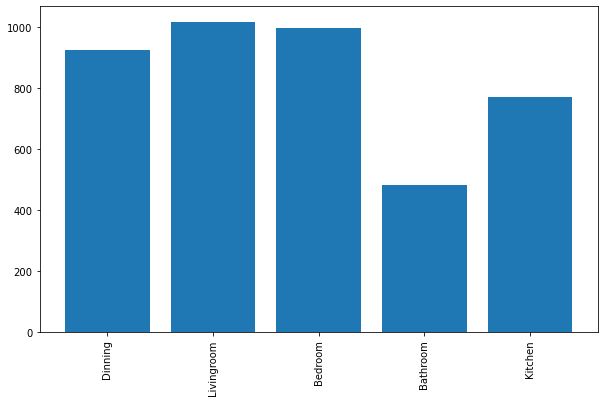

In [10]:
#If we just use the original data, this is quite skew... Later..
def ShowClassDist(train_dir):
    class_counts = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):
        if len(dirnames)!=0:
            class_list = dirnames
        
        if len(filenames)>0:
            class_counts.append(len(filenames))
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(class_list, class_counts)
    plt.xticks(fontsize=10, rotation=90)
    plt.show()
ShowClassDist(train_dir)

## Build a Convolutional Neural Network(CNN) Architecture 

- Now, we will build a custom CNN model. In the model, we will have 128,64,32 and 16 convolutional layer(feature maps) followed by a fully connected layer with 64 neurons. Such an order is very common in practice.
- A typical CNN layer is followed by activation function, then [Batch Normalization](https://www.youtube.com/watch?v=dXB-KQYkzNU) and then [Pooling](https://www.youtube.com/watch?v=ZjM_XQa5s6s) operation. Click on the links to learn more about these items. 
- Instead of writing the same structure again over again, we can simply define two functions returning such structures and call them one after another. However, one can achieve the same task by defining each of these items one by one. I include both down there;

In [11]:
# # nice way of building a model
def Get2dConv(in_channels,out_channels):
    
    return nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(out_channels),
                        nn.MaxPool2d(kernel_size=2,stride=2)
                        )
def GetLinear(in_features,out_features):
    
    return nn.Sequential( nn.Linear(in_features,out_features),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(out_features)
                      )

# Extent nn.Module to create a new model. Use for loop above to do this easily
class HouseModel(nn.Module):
    def __init__(self):
        super(HouseModel,self).__init__()
        self.conv1 = Get2dConv(3,32)
        self.conv2 = Get2dConv(32,32)
        self.conv3 = Get2dConv(32,64)
        
        
        
        self.fc1 = GetLinear(64*5*5,128)
        
        self.out = nn.Linear(in_features=128,out_features=num_classes)
     
    
    def forward(self, t):
        t = self.conv1(t)
        t = self.conv2(t)
        t = self.conv3(t)
        
       

        t = torch.flatten(t,1)

        t = self.fc1(t)
        t = self.out(t)
       
        return t

In [12]:
# long and inefficient way but maybe easier
class HouseModel(nn.Module):
    def __init__(self):
        super(HouseModel,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.batch1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(32,32,kernel_size=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.batch2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv3 = nn.Conv2d(32,64,kernel_size=3)
        self.relu3 = nn.ReLU(inplace=True)
        self.batch3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        

        self.fc = nn.Linear(in_features=64*5*5,out_features=128)
        self.bn = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        

        self.out = nn.Linear(in_features=128,out_features=num_classes)
     
    
    def forward(self, t):
        t = self.relu1(self.batch1(self.conv1(t)))
        t = self.pool1(t)

        t = self.relu2(self.batch2(self.conv2(t)))
        t = self.pool2(t)

        t = self.relu3(self.batch3(self.conv3(t)))
        t = self.pool3(t)


        t = torch.flatten(t,1)

        t = self.relu(self.bn(self.fc(t)))        

        t = self.out(t)
       
        return t

In [13]:
model = HouseModel()
summary(model,input_size=(batch_size,3,60,60))

Layer (type:depth-idx)                   Output Shape              Param #
HouseModel                               --                        --
├─Conv2d: 1-1                            [10, 32, 58, 58]          896
├─BatchNorm2d: 1-2                       [10, 32, 58, 58]          64
├─ReLU: 1-3                              [10, 32, 58, 58]          --
├─MaxPool2d: 1-4                         [10, 32, 29, 29]          --
├─Conv2d: 1-5                            [10, 32, 27, 27]          9,248
├─BatchNorm2d: 1-6                       [10, 32, 27, 27]          64
├─ReLU: 1-7                              [10, 32, 27, 27]          --
├─MaxPool2d: 1-8                         [10, 32, 13, 13]          --
├─Conv2d: 1-9                            [10, 64, 11, 11]          18,496
├─BatchNorm2d: 1-10                      [10, 64, 11, 11]          128
├─ReLU: 1-11                             [10, 64, 11, 11]          --
├─MaxPool2d: 1-12                        [10, 64, 5, 5]            --
├─Line

### What CNNs Learn

In each conv2d-RelU-BatchNorm-MaxPool block, here is what happens:

**(1) Apply convolution**

- input = in_channel x H x W

- filter_size = out_channel X in_channel x Kernel x Kernel 

- conv_output = out_channel X H_c x W_c

**(2) apply ReLU and batch normalization**

**(3) apply pooling layer**

- pooling_filter_size = out_channel x pool_kernel x pool_kernel 

- pool_output = out_channel x H_p X W_p

For example, lets look at the first block

(1)  apply convolution

- input = 3 x 60 x 60

- filter_size = 32 x 3 x 3 x 3 **(these are the parameters we learn!)**

- conv_output = 32 x 58 x 58

(2) apply ReLU and batch normalization(no size change)

(3) apply pooling layer
- pooling_filter_size = 32 x 2 x 2
- pool_output = 32 x 29 x 29

Now we would like to visualize what filters and feature maps after each convolution operation.

In [14]:
def GetCnnWeights(model):
    model_child_list = list(model.children())
    weight_list = []
    conv_layer_list = []
    for i in range(len(model_child_list)):
        if type(model_child_list[i])==nn.Conv2d:
            conv_layer_list.append(model_child_list[i])
            weight_list.append(model_child_list[i].weight)
    print(f'we have {len(conv_layer_list)} convolutional layers')
    return weight_list,conv_layer_list

weight_list,conv_layer_list = GetCnnWeights(model)

we have 3 convolutional layers


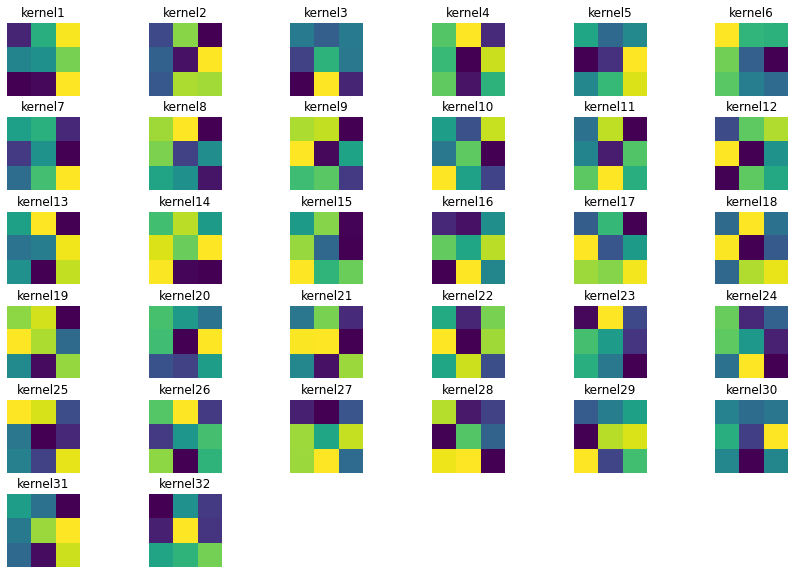

In [15]:
def PlotFilters(weight_list,layer_num=0):    
    plt.figure(figsize=(15, 10))
    h = int(np.ceil(np.sqrt(weight_list[layer_num].shape[0])))
    for i, filters in enumerate(weight_list[layer_num]):
        plt.subplot(h, h, i+1) # 
        plt.subplots_adjust(hspace=0.3,wspace=0.1)
        #filters = filters - filters.min()
        #filters = filters / filters.max()
        plt.imshow(filters[0, :, :].detach().type(torch.FloatTensor).numpy())
        plt.title(f'kernel{i+1}')
        plt.axis('off')
    plt.show()

PlotFilters(weight_list,layer_num=0)

Following function plots all the feature maps after the given layer. Pick any image from either training or testing and provide the necessary transformation. Given the conv_layer_list list, we visualize how each feature map of this particular image looks like. Notice that how each of these the filters above reveal a **certain** patterns. However, note that such an analysis must be done after training the model since the model did not learn anything at this point.

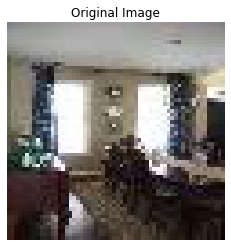

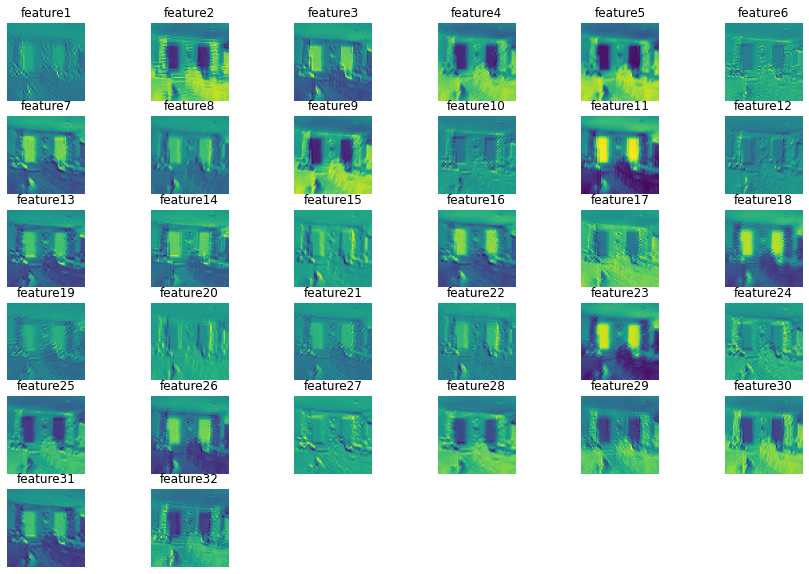

In [16]:
#for now, let's display only after the first convolutional layer
def PlotFeatureMaps(img_path,conv_layer_list,transform_type = test_transforms ,layer=0):
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    img = test_transforms(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    conv = conv_layer_list[layer].to(device)
    ouput = conv(img)
    h = int(np.ceil(np.sqrt(ouput[0].shape[0])))
    plt.figure(figsize=(15, 10))
    for i, image in enumerate(ouput[0]):
        #image = image - image.min()
        #image = image / image.max()
        plt.subplot(h,h,i+1)
        plt.imshow(image.detach().type(torch.FloatTensor).numpy())
        plt.title(f'feature{i+1}')
        plt.axis('off')
        #plt.show()

PlotFeatureMaps(test_image_paths[69],conv_layer_list,transform_type = test_transforms,layer=0)        

## Train and Test


- In a typical supervised learning task, we have training and testing functions. We then call this functions in order to monitor the progress of our model. More precisely, train and test the model in each epoch.
- It is always a good practice to save the 'best performing model'. This means, we will keep track of the 'best accuracy' in each epoch and save the model achieving that best accuracy. This is important because we can then load this model and start training from where we left off. We will use SaveModel and LoadModel functions for this purpose.
-CNN is better than fully connected neural network,we can make it better. We will discuss about potential improvement techniques in the later sections such as **"hyperparameter optimization", "data augmentation"**.


In [17]:
def TrainHouseModel(model, train_loader, optimizer,epoch,log_int):
   
    # set to train mode
    model.train()
    
    #send to cuda/GPU
    model.to(device)
    
    #loss function
    criterion = nn.CrossEntropyLoss()

    # compute the train loss and correct predictions per epoch
    train_loss = 0.0
    total_train_correct = 0
    
    
    for i,(images, labels) in enumerate(train_loader):
        #clear the cuda cache
        torch.cuda.empty_cache()
        
        #send to cuda
        images = images.to(device)
        labels = labels.to(device)
        
        # FORWARD PASS
        #compute the prediction for the batch
        outputs = model(images)

        # compute the loss
        loss = criterion(outputs, labels)

        
        #BACK-PROPOGATION
        # compute the gradient
        loss.backward()

        # update the weights and biases/ gradient decent
        optimizer.step()

        #GET SOME METRICS
        # compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * images.size(0)

        # compute the predictions for each class
        predictions = outputs.argmax(dim=1)

        # boolen compare the predictions vs targets and create the correct count tensor
        correct_counts = predictions.eq(labels)
        
        # accumulate the total test correct and update over the batches.
        total_train_correct += correct_counts.sum().item()

        #zero out before each backpropagation.
        optimizer.zero_grad()

    # training loss and training accuracy for the epoch/one complete cycle
    avg_train_loss = train_loss/len(train_loader.dataset) 
    avg_train_acc = total_train_correct/float(len(train_loader.dataset))
    
    #print in every 'log_int' steps. 
    if epoch%log_int==0:
        print(f'train_loss: {avg_train_loss:0.5f} train_acc: {avg_train_acc:0.2f}')
    
    return avg_train_acc,avg_train_loss

In [18]:
def TestHouseModel(model, test_loader,epoch,log_int):
    # For testing, no need to track gradients. 
    model.eval()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.
    total_test_correct = 0
    with torch.no_grad():
        for j,(images, labels) in enumerate(test_loader):
            torch.cuda.empty_cache()
            images = images.to(device)
            labels = labels.to(device)

            # FORWARD PASS
            outputs = model(images)

            # compute the loss
            loss = criterion(outputs, labels)

            #GET SOME METRICS
            # compute the loss for the batch and add it to total test_loss
            test_loss += loss.item() * images.size(0)

            # compute the predictions
            predictions = outputs.argmax(dim=1)

            # boolen compare the predictions vs labels and create the correct count tensor
            correct_counts = predictions.eq(labels)

            # accumulate the total test correct and update over the batches.
            total_test_correct += correct_counts.sum().item()

    # test loss and test accuracy for the epoch/one complete cycle
    
    avg_test_loss = test_loss/len(test_loader.dataset) 
    avg_test_acc = total_test_correct/float(len(test_loader.dataset))
    
    #print in every 'log_int' steps. 
    if epoch%log_int==0:
        print(f'test_loss: {avg_test_loss:0.4f} test_acc: {avg_test_acc:0.2f}\n')

    return avg_test_acc, avg_test_loss

In [19]:
def SaveModel(model,optimizer, name,beststats):
    checkpoint = { 'state_dict':  model.state_dict(),
                   'optim_state': optimizer.state_dict(),
                   'best_stats':  beststats
                 }
    path = ext_dir + "/" + name +".pth"
    torch.save(checkpoint, path )

def LoadModel(model,filepath):
    #load the model and assign the pre-trained weights
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    model.best_scores = checkpoint['best_stats']
    
    return model

This is the driver function to train our model. There are couple of things we should pay attention
- We train the model on training set get accuracy and loss and then immediately test the accuracy and loss on testing data. We are mostly interested in the second part. Even though, the loss is going down and the accuracy is going up(even 99%) on training data, the model is useless unless it equally performs on *testing* data as well.
- Again, there are tons of things we can do to remedy this issue but let's learn the necessary tools for now.

In [20]:
def StartTraining(model,lr,num_epochs,log_int):    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    max_acc = 0.
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        avg_train_acc, avg_train_loss =TrainHouseModel(model, train_loader, optimizer,epoch,log_int)
        avg_test_acc, avg_test_loss = TestHouseModel(model,test_loader,epoch,log_int)

        if avg_test_acc > max_acc:
            max_acc = avg_test_acc
            beststats = {'BestTestAcc':     max_acc ,  
                         'lr':              lr,
                        'batch_size':       batch_size,
                        }

            SaveModel(model,optimizer,'HouseModelCNN',beststats)
        train_loss_list.append(avg_train_loss)
        test_loss_list.append(avg_test_loss)
    torch.cuda.empty_cache()
    return train_loss_list,test_loss_list

In [24]:
train_loss_list,test_loss_list =  StartTraining(model = HouseModel(),lr = 1e-3,num_epochs = 50,log_int=10)

train_loss: 1.38541 train_acc: 0.40
test_loss: 1.3191 test_acc: 0.44

train_loss: 0.24588 train_acc: 0.92
test_loss: 1.7593 test_acc: 0.55

train_loss: 0.11000 train_acc: 0.96
test_loss: 2.3541 test_acc: 0.52

train_loss: 0.08594 train_acc: 0.97
test_loss: 2.6026 test_acc: 0.49

train_loss: 0.07601 train_acc: 0.97
test_loss: 2.8075 test_acc: 0.50



- We can see below, the model is overfitting. In fact, the test loss is getting worse. There are established procedures to avoid it but we will reserve them in the next notebook.
- Carefully note that, we had achieved close to 34% with ~1 millions parameter with a fully connected neural network. But now, we achieved 51% with only 230K parameters. This is the power of CNNs...

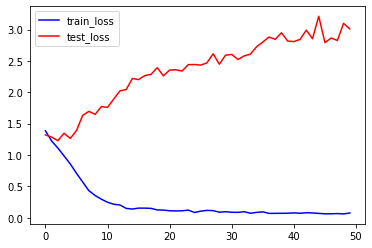

In [25]:
#what we see here is called "overfitting".
num_epochs = 50
eps = np.linspace(0,num_epochs-1,num_epochs)
plt.plot(eps,train_loss_list,'b-',eps,test_loss_list,'r-')
plt.legend(['train_loss','test_loss'])
plt.show()

## Post-Processing

First let's load the saved model and use it to evaluate our model performance

In [26]:
#this will reload the model with 'learned parameters'
model = LoadModel(HouseModel(),'results/House_Rooms/HouseModelCNN.pth')
model.best_scores

{'BestTestAcc': 0.5456273764258555, 'lr': 0.001, 'batch_size': 10}

### Display The Predictions with Ground Truths

In [ ]:
@torch.no_grad()
def GetClassProbs(model,image_path, topk=3):
    model.to(device)
    model.eval()
    img = Image.open(image_path).convert("RGB")
    label = image_path.split('/')[-2]
    #mean = [0.485, 0.456, 0.406]
    #std =  [0.229, 0.224, 0.225]
    #tfm = transforms.Compose([transforms.Normalize(mean,std),transforms.ToTensor()])
    tfm = transforms.Compose([transforms.ToTensor()])
    img = tfm(img)
    img = img.unsqueeze(0).to(device)
    output = model(img)
    #get probabilities
    probs = F.softmax(output) 
    top_probabilities, top_indices = probs.topk(topk)
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes

In [ ]:
def ShowPredictions(n):
    plt.subplots(n,2,figsize=(12, 4*n)) 
    plt.subplots_adjust(0,0,3,3,wspace = 0.5)
    for i in range(1,n+1):
        rnd_number = random.randint(0,len(test_image_paths))
        img_path = test_image_paths[rnd_number]
        label = img_path.split('/')[-2]
        #windows
        #label = (img_path.split('/')[-1]).split('\\')[-2]
        image = Image.open(img_path).convert("RGB")
        plt.subplot(n,2,2*i-1)
        plt.title(label)
        plt.imshow(image)
        probs, classes = GetClassProbs(model,img_path, topk=3)
        plt.subplot(n,2,2*i)
        plt.barh(classes, probs,align='center')
        plt.tight_layout()
    plt.show()

In [ ]:
ShowPredictions(3)

In [ ]:
ShowPredictions(3)

### Visualize the Filters and Feature Maps Again

we have 3 convolutional layers


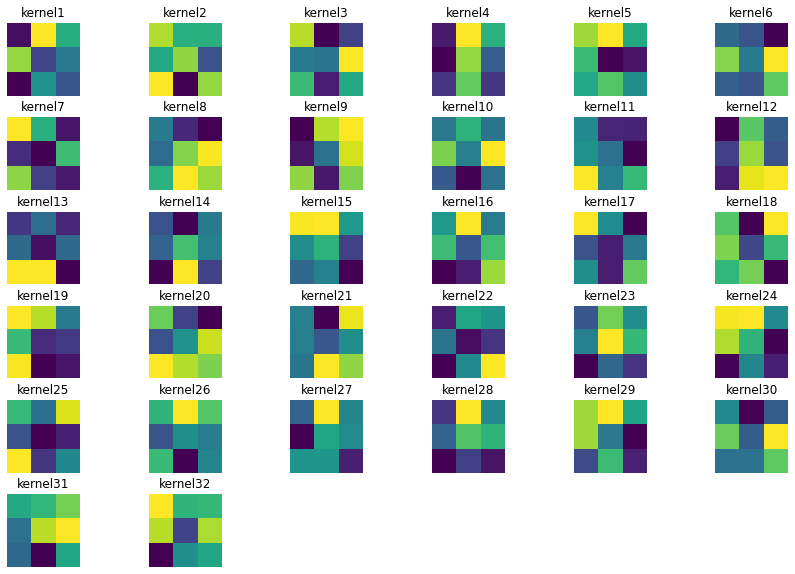

In [28]:
weight_list,conv_layer_list = GetCnnWeights(model)
PlotFilters(weight_list,layer_num=0)

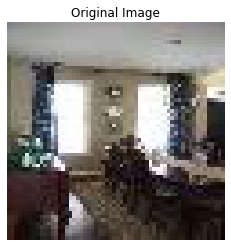

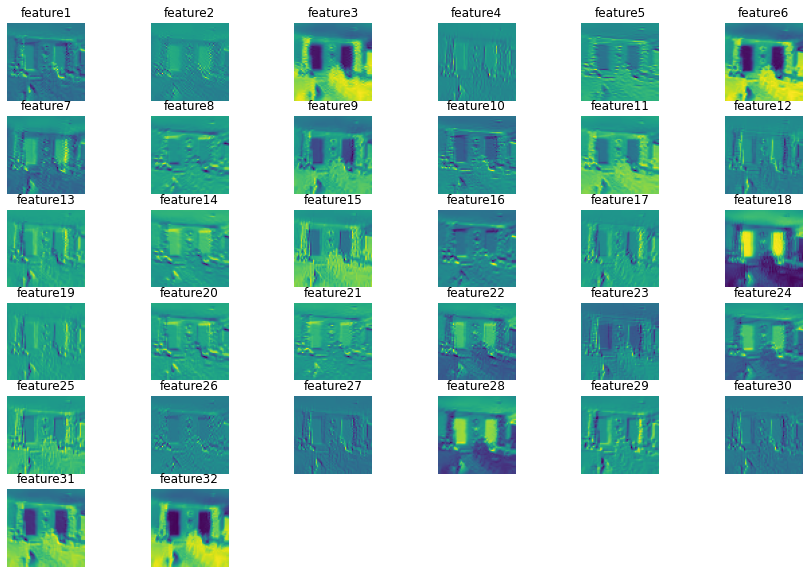

In [29]:
PlotFeatureMaps(test_image_paths[69],conv_layer_list,transform_type = test_transforms,layer=0)  

### Evaluate the Performance Metrics
- For more details, consult to our lecture notes resources folder in this repo

#### Confusion Matrix
- The most important outcome of a classification problem is the confusion matrix. Each **row** of the matrix represents the instances **actual class** while each **column** represents the instances in a **predicted class**. 
-  Confusion matrix allows us to determine all the necessary metrics to evaluate the performance of an image classification model. First of all, let's see how we interpret confusion matrix for a simple scenario.
- Notice that comparing the previous model in Part-1, the metrics are way better.

In [30]:
def GetConfusionMatrix(model, test_loader):
    with torch.no_grad():
        model.eval()
        model.to(device)
        all_preds  = torch.FloatTensor([]).to(device)
        all_labels = torch.LongTensor([]).to(device)
        #compute all predictions
        for images, labels in iter(test_loader):
            images,labels = images.to(device),labels.to(device)
            preds = model(images)
            all_preds = torch.cat(
                (all_preds,preds),
                dim=0
            )
            all_labels = torch.cat((all_labels,labels),dim=0)
        
        #get the predicted labels
        preds = all_preds.argmax(dim=1)
        #create confusion matrix
        cm = confusion_matrix(all_labels.cpu().numpy(), preds.cpu().numpy())
        return cm
cm = GetConfusionMatrix(model,test_loader)

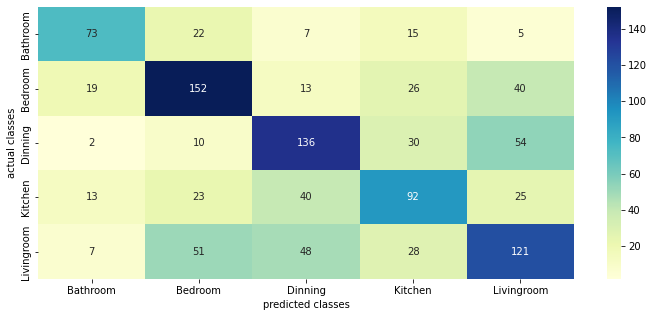

In [31]:
#display confusion matrix. truth:x_axis(rows), preds:y_axis(cols)
df_cm = pd.DataFrame(cm, index = [i for i in class_list], columns = [i for i in class_list])
plt.figure(figsize=(12,5))
sns.heatmap(df_cm,annot=True,cmap="YlGnBu",fmt='g')
plt.xlabel('predicted classes')
plt.ylabel('actual classes')
plt.show()

#### Overall Accuracy

In [32]:
def DisplayScores(class_list,scores,score_type = ''):
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(class_list, scores)
    ax.bar_label(ax.containers[0],fmt='%.2f')
    ax.set_xticklabels(class_list, rotation=90)
    ax.set_title('mean_' + score_type +':'+ str(round(scores.mean(),ndigits=2)))
    plt.show()

In [33]:
# Be cautius, not always the best way
OveralAcc = np.sum(np.diag(cm))/np.sum(cm)
print('OverallAccuracy', OveralAcc)

OverallAccuracy 0.5456273764258555


#### Recall
- Recall tells us the ability of algoritm to classify a particular class. 

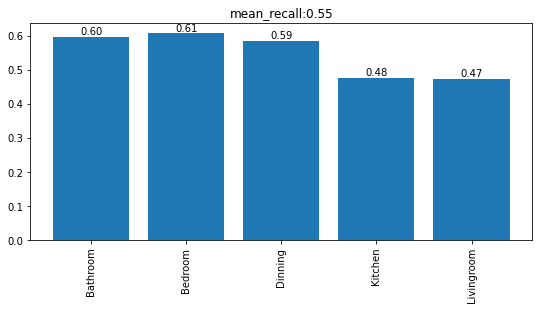

In [34]:
recalls = np.diag(cm)/np.sum(cm,axis = 1)
DisplayScores(class_list,recalls,'recall')

#### Precision
- Precision for a class tells us the ability of an alg **not to label anything as that class**. 

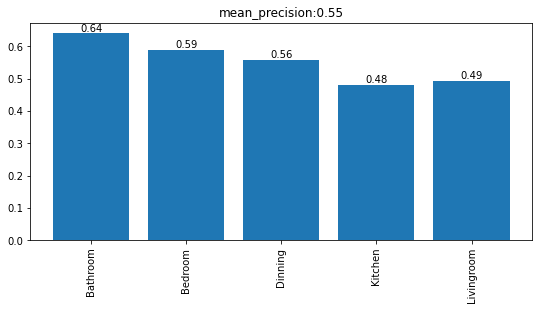

In [35]:
precisions = np.diag(cm)/np.sum(cm,axis = 0)
DisplayScores(class_list,precisions,'precision')

#### F1-Score
This is the harmonic average of recall recall and precision. It is a reliable measure putting equal weights on precision and recall. It sits somewhere between precision and recall. 

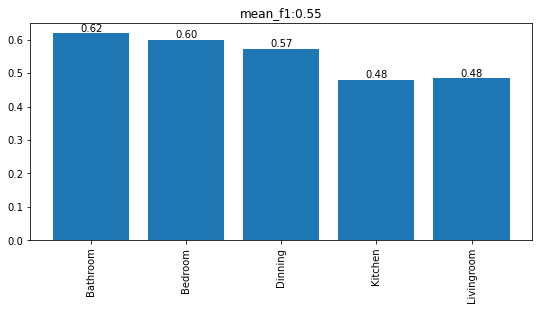

In [36]:
f1 = 2/(1/recalls + 1/precisions)
DisplayScores(class_list,f1,'f1')